## Import packages

#### This code has been modified from the source which can be found at https://github.com/fabiobdias/waom_notebook

In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps


from shapely.ops import cascaded_union

# for gsw
import sys
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
import gsw

In [2]:
from xgcm import Grid
import warnings
warnings.filterwarnings('ignore')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Set up the datasets

In [4]:
ds1  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0001.nc")
ds2  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0002.nc")
ds3  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0003.nc")
ds4  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0004.nc")
ds5  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0005.nc")
ds6  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0006.nc")
ds7  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0007.nc")
ds8  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0008.nc")
ds9  = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0009.nc")
ds10 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0010.nc")
ds11 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0011.nc")
ds12 = xr.open_dataset("/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0012.nc")

In [5]:
ds1

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 560,
                    xi_rho: 630, eta_u: 560, xi_u: 629, eta_v: 559, xi_v: 630,
                    eta_psi: 559, xi_psi: 629, ocean_time: 4)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
    x_u            (eta_u, xi_u) float64 ...
    y_u            (eta_u, xi_u) float64 ...
    x_v            (eta_v, xi_v) float64 ...
    y_v            (eta_v, xi_v) float64 ...
    x_psi          (eta_psi, xi_psi) float64 ...
    y_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2026-12-30T19:15:00 ... 2027-0...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/95)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    v_temp         (ocean_time, s_rho, eta_v, xi_v) float32 ...
    u_salt         (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v_salt         (ocean_time, s_rho, eta_v, xi_v) float32 ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    swrad          (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/35)
    file:              /scratch/project_2000789/muramarg/waom_total/output_WA...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS nonlinear model averages file
    title:             Whole Antarctic and Ocean Application, 10 km resolution
    rst_file:          /scratch/project_2000789/muramarg/waom_total/output_WA...
    ...                ...
    compiler_command:  /appl/spack/v018/install-tree/intel-2021.6.0/intel-one...
    compiler_flags:    -heap-arrays -fp-model precise -g -check bounds -trace...
    tiling:            016x016
    history:           ROMS/TOMS, Version 3.7, Thursday - May 25, 2023 -  1:0...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       WAOM10, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ...

In [6]:
idx = 0
dg = xr.open_dataset("/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc")
lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]

dens1 = np.zeros((4,31,560,630))
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(idx)
    
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]

    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    #print(Zo_rho.shape)
    #print(ds.zeta.shape,ds.h.shape,ds.zice.shape)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
    
    #print(z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho").shape)
    ds.coords['z_rho'] = z_rho.transpose("ocean_time", "s_rho","eta_rho","xi_rho")

    # read grid file for lon/lat coordinates
    ds.coords['lat_rho']=lat_rho#.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho#.transpose() # put lon_rho into ds dataset
    
    dens1 = dens1 + gsw.rho(salt,temp,0)-1000
    idx += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [7]:
dens = dens1/12

In [8]:
def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(0,-63.8,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-60,-55,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-120,-54.7,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(180,-62,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return

proj = ccrs.SouthPolarStereo()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)

bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

In [9]:
# Handle interpolation from u and v grid to rho points:
# loop through the datasets and do the averaging
i = 0

for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print(i)

    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11


In [10]:
# call cartopy projectione
proj = ccrs.SouthPolarStereo()

# re-gridding
src = ccrs.SouthPolarStereo()
nx, ny = 630, 560

In [11]:
fig_path='/scratch/project_2000789/muramarg/reviews1/'

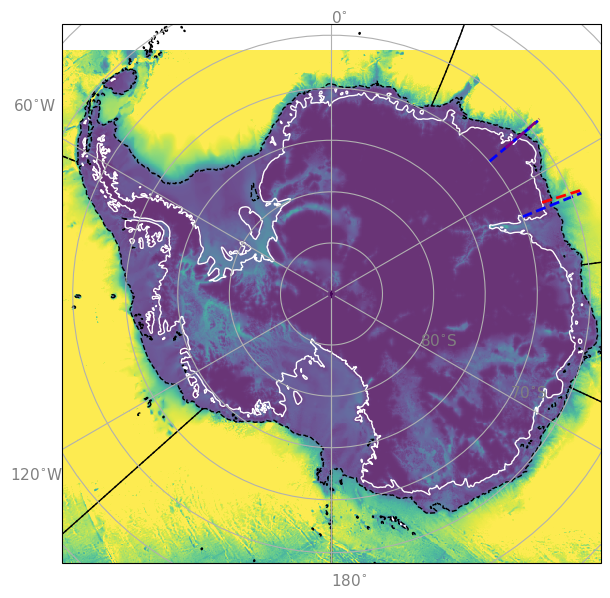

In [12]:
# 1 - slice section for salt/temp/z_rho
xi_ini =       [485, 0, 524]
xi_end =       [521, 0, 565]
eta_sec_ini =  [455, 0, 397]
eta_sec_end =  [486, 0, 410]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
# cc = plt.pcolormesh(lon_rho.transpose(), lat_rho.transpose(), ds.h, transform=ccrs.PlateCarree(), vmin=0, vmax=3000)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds.h.isel(),transform=ccrs.PlateCarree(),
               alpha=0.8,vmax=4000)
ax.gridlines()
ax.coastlines(resolution='50m',color='white')
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)

# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_ini[ii]], lon_rho[eta_sec_end[ii],xi_end[ii]]],[lat_rho[eta_sec_ini[ii],xi_ini[ii]], lat_rho[eta_sec_end[ii],xi_end[ii]]],
         color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')

ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_ini[ii]], lon_rho[eta_sec_end[ii],xi_end[ii]]],[lat_rho[eta_sec_ini[ii],xi_ini[ii]], lat_rho[eta_sec_end[ii],xi_end[ii]]],
         color='purple',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed',zorder=5)


# try to plot with lat and long
lon_ini = [50,68]
lon_end = [50,68]
lat_ini = [-70,-70]
lat_end = [-64,-64]

ii = 0
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]], color='blue', transform=ccrs.PlateCarree(), linewidth=2, linestyle='dashed')
ii = 1
plt.plot([lon_ini[ii], lon_end[ii]], [lat_ini[ii], lat_end[ii]], color='blue', transform=ccrs.PlateCarree(), linewidth=2, linestyle='dashed')


lonlat_labels(ax)
ax.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())

name_fig="locations.png"
# plt.savefig(fig_path + name_fig)
plt.show()

### Make the figure

In [ ]:
# Initialize an empty list to store the diagonal points
diagonal_points = []

# Iterate over the indices of the ranges
i = 0
xi_range = np.arange(xi_ini[i], xi_end[i] + 1)
eta_range = np.arange(eta_sec_ini[i], eta_sec_end[i] + 1)
min_range = min(len(xi_range), len(eta_range))

diagonal_points.extend([(xi_range[j], eta_range[j]) for j in range(min_range)])

# Convert the list of tuples to a numpy array
diagonal_points_array50 = np.array(diagonal_points)

# Print the array of points on the diagonal
# print(diagonal_points_array50)

In [ ]:
# Ross Sea
loc = 2

# 1 - slice section for salt/temp/z_rho
section_salt_rosE = np.empty((3,31,32)) # allocating
section_temp_rosE = np.empty((3,31,32))
section_rho_rosE = np.empty((3,31,32))
section_z_rosE = np.empty((3,31,32))
section_z_rosE_mask = np.empty((3,31,32))

for mm in np.arange(0,2):
    print(mm)
    
    # create the mean values first
    salt_mean = (np.swapaxes(np.diagonal(ds1.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.salt.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12
    temp_mean = (np.swapaxes(np.diagonal(ds1.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.temp.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12
    z_rho_mean = (np.swapaxes(np.diagonal(ds1.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.z_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12  
    
    # now add them to the matrix
    section_salt_rosE[mm,:,:] = salt_mean
    section_temp_rosE[mm,:,:] = temp_mean
    section_z_rosE[mm,:,:] = z_rho_mean
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
    section_rho_rosE[mm,:,:] = np.swapaxes(np.diagonal(np.squeeze(dens[mm, :, diagonal_points_array50[:, 1], diagonal_points_array50[:, 0]]), axis1=1, axis2=2).T, 0, 1)
        
# 2 - slide section for lon or lat
#section_lat_rosE_tmp = dg.lat_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc])
section_lat_rosE_tmp = np.diagonal(dg.lat_rho.isel(xi_rho=diagonal_points_array50[:, 0], eta_rho=diagonal_points_array50[:, 1]).values).T

# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosE = np.ones((31,32))                                                
for ii in np.arange(0,31):
    section_lat_rosE[ii,:] = section_lat_rosE_tmp
section_lat_rosE_mask = ma.array(section_lat_rosE,mask=np.isnan(section_z_rosE[0,:,:]))

print(section_lat_rosE.shape, section_z_rosE.shape, section_salt_rosE.shape)

## season averages:
section_z_rosE_mask_JFM = np.squeeze(np.nanmean(section_z_rosE_mask[0:2,:,:], axis=0))
section_temp_rosE_JFM = np.squeeze(np.nanmean(section_temp_rosE[0:2,:,:], axis=0))
section_salt_rosE_JFM = np.squeeze(np.nanmean(section_salt_rosE[0:2,:,:], axis=0))
section_rho_rosE_JFM = np.squeeze(np.nanmean(section_rho_rosE[0:2,:,:], axis=0))

section_z_rosE_mask_ann = np.squeeze(np.nanmean(section_z_rosE_mask[:,:,:], axis=0))
section_temp_rosE_ann = np.squeeze(np.nanmean(section_temp_rosE[:,:,:], axis=0))
section_salt_rosE_ann = np.squeeze(np.nanmean(section_salt_rosE[:,:,:], axis=0))
section_rho_rosE_ann = np.squeeze(np.nanmean(section_rho_rosE[:,:,:], axis=0))

print(section_lat_rosE.shape, section_z_rosE_mask_JFM.shape, section_salt_rosE_JFM.shape)

In [ ]:
# Plot transects: Seasonal
levelsT = np.arange(-1.9,1,.25)
levelsS = np.arange(33.8,34.7,.05)
levelsR = np.arange(27.17,27.75,.02)

# Ross East
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,3,1)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, colors='k', levels=levelsT,linestyles="solid")
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct,label="$θ$")
plt.xlim([-67.2,-64.2])
plt.ylim([-1500,0])
plt.suptitle('50$^\circ$E - Annual Mean',fontsize=16)
plt.ylabel('Depth (m)')

ax2 = fig.add_subplot(1,3,2)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs,label="S")
plt.xlim([-67.2,-64.2])
plt.ylim([-1500,0])

ax3 = fig.add_subplot(1,3,3)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='k', levels=levelsR)
cbar = plt.colorbar(cs,label="$\sigma_{θ}$")
cbar.ax.invert_yaxis()
plt.xlim([-67.2,-64.2])
plt.ylim([-1500,0])

ax2.set_yticks([])
ax3.set_yticks([])

name_fig="annual_50deg_transecta.png"
# plt.savefig(fig_path + name_fig)

plt.show()


In [ ]:
rho50 = section_rho_rosE_JFM
section_lat_rosE_mask50 = section_lat_rosE_mask
section_z_rosE_mask_JFM50 = section_z_rosE_mask_JFM

In [ ]:
# Initialize an empty list to store the diagonal points
diagonal_points = []

# Iterate over the indices of the ranges
i = 2
xi_range = np.arange(xi_ini[i], xi_end[i] + 1)
eta_range = np.arange(eta_sec_ini[i], eta_sec_end[i] + 1)
min_range = min(len(xi_range), len(eta_range))

diagonal_points.extend([(xi_range[j], eta_range[j]) for j in range(min_range)])

# Convert the list of tuples to a numpy array
diagonal_points_array68 = np.array(diagonal_points)

# Print the array of points on the diagonal
# print(diagonal_points_array68)

In [ ]:
# Ross Sea
loc = 2

# 1 - slice section for salt/temp/z_rho
section_salt_rosE = np.empty((3,31,14)) # allocating
section_temp_rosE = np.empty((3,31,14))
section_rho_rosE = np.empty((3,31,14))
section_z_rosE = np.empty((3,31,14))
section_z_rosE_mask = np.empty((3,31,14))

for mm in np.arange(0,2):
    print(mm)
    
    # create the mean values first
    salt_mean = (np.swapaxes(np.diagonal(ds1.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.salt.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12
    temp_mean = (np.swapaxes(np.diagonal(ds1.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.temp.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12
    z_rho_mean = (np.swapaxes(np.diagonal(ds1.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds2.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds3.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds4.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds5.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds6.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds7.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds8.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds9.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds10.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds11.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1)+
                 np.swapaxes(np.diagonal(ds12.z_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1], ocean_time=mm).values,axis1=1,axis2=2).T,0,1))/12  
    
    # now add them to the matrix
    section_salt_rosE[mm,:,:] = salt_mean
    section_temp_rosE[mm,:,:] = temp_mean
    section_z_rosE[mm,:,:] = z_rho_mean
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
    section_rho_rosE[mm,:,:] = np.swapaxes(np.diagonal(np.squeeze(dens[mm, :, diagonal_points_array68[:, 1], diagonal_points_array68[:, 0]]), axis1=1, axis2=2).T, 0, 1)
        
# 2 - slide section for lon or lat
#section_lat_rosE_tmp = dg.lat_rho.isel(xi_rho=slice(xi_ini[loc],xi_end[loc]), eta_rho=eta_sec_ini[loc])
section_lat_rosE_tmp = np.diagonal(dg.lat_rho.isel(xi_rho=diagonal_points_array68[:, 0], eta_rho=diagonal_points_array68[:, 1]).values).T

# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosE = np.ones((31,14))                                                
for ii in np.arange(0,31):
    section_lat_rosE[ii,:] = section_lat_rosE_tmp
section_lat_rosE_mask = ma.array(section_lat_rosE,mask=np.isnan(section_z_rosE[0,:,:]))

print(section_lat_rosE.shape, section_z_rosE.shape, section_salt_rosE.shape)

## season averages:
section_z_rosE_mask_JFM = np.squeeze(np.nanmean(section_z_rosE_mask[0:2,:,:], axis=0))
section_temp_rosE_JFM = np.squeeze(np.nanmean(section_temp_rosE[0:2,:,:], axis=0))
section_salt_rosE_JFM = np.squeeze(np.nanmean(section_salt_rosE[0:2,:,:], axis=0))
section_rho_rosE_JFM = np.squeeze(np.nanmean(section_rho_rosE[0:2,:,:], axis=0))

section_z_rosE_mask_ann = np.squeeze(np.nanmean(section_z_rosE_mask[:,:,:], axis=0))
section_temp_rosE_ann = np.squeeze(np.nanmean(section_temp_rosE[:,:,:], axis=0))
section_salt_rosE_ann = np.squeeze(np.nanmean(section_salt_rosE[:,:,:], axis=0))
section_rho_rosE_ann = np.squeeze(np.nanmean(section_rho_rosE[:,:,:], axis=0))

print(section_lat_rosE.shape, section_z_rosE_mask_JFM.shape, section_salt_rosE_JFM.shape)

In [ ]:
# Plot transects: Seasonal
levelsT = np.arange(-1.9,1,.25)
levelsS = np.arange(33.8,34.7,.05)
levelsR = np.arange(27.17,27.75,.02)

# Ross East
fig = plt.figure(figsize=(16,4))
fig.tight_layout()
ax1 = fig.add_subplot(1,3,1)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, colors='k', levels=levelsT,linestyles="solid")
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct,label="$θ$")
plt.xlim([-67.9,-66.23])
plt.ylim([-1500,0])
plt.suptitle('68$^\circ$E - Annual Mean',fontsize=16)
plt.ylabel('Depth (m)')
ax1.set_xticks([-67.5,-67,-66.5])
#plt.xlabel('Latitude')
# plt.title()

ax2 = fig.add_subplot(1,3,2)
cs = ax2.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, levels=levelsS, cmap=plt.cm.viridis)
ax2.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs,label="S")
ax2.set_yticks([])
plt.xlim([-67.9,-66.23])
ax2.set_xticks([-67.5,-67,-66.5])
plt.ylim([-1500,0])
plt.xlabel('Latitude')
# plt.title("S")

ax3 = fig.add_subplot(1,3,3)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='k', levels=levelsR)
cbar = plt.colorbar(cs,label="$\sigma_{θ}$")
cbar.ax.invert_yaxis()
ax3.set_yticks([])
plt.xlim([-67.9,-66.23])
ax3.set_xticks([-67.5,-67,-66.5])
plt.ylim([-1500,0])
# plt.title()

name_fig="annual_68deg_transecta.png"
# plt.savefig(fig_path + name_fig)

plt.show()

### Create a contour of lateral density gradient

In [ ]:
# # 50
# a,b = diagonal_points_array50[0],diagonal_points_array50[1]
# dx = np.linalg.norm(a-b)     # in 10s of km
# dx *= 10                     # km
# dx *= 1000                   # m
# d_rho_dx50 = np.gradient(rho50, axis=1) / dx
# d2_rho_dx250 = np.gradient(d_rho_dx50, axis=1) / dx


# # 68
# rho68 = section_rho_rosE_JFM
# a,b = diagonal_points_array68[0],diagonal_points_array68[1]
# d_rho_dx68 = np.gradient(rho68, axis=1) / dx
# d2_rho_dx268 = np.gradient(d_rho_dx68, axis=1) / dx



# fig = plt.figure(figsize=(16,4))
# fig.tight_layout()
# ax1 = fig.add_subplot(1,2,1)
# cs = plt.contourf(section_lat_rosE_mask50,section_z_rosE_mask_JFM50, d_rho_dx50, cmap=plt.cm.gnuplot)
# plt.contour(section_lat_rosE_mask50,section_z_rosE_mask_JFM50, d_rho_dx50, colors='k')
# plt.colorbar(cs,label="$\sigma_{θ}$")
# ax3.set_yticks([])
# plt.xlim([-67.2,-64.2])
# ax3.set_xticks([-67.5,-67,-66.5])
# plt.ylim([-1500,0])


# ax3 = fig.add_subplot(1,2,2)
# cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, d_rho_dx68, cmap=plt.cm.gnuplot)
# plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, d_rho_dx68, colors='k')
# plt.colorbar(cs,label="$d^2\sigma_{θ}/ dx^2$")
# ax3.set_yticks([])
# plt.xlim([-67.9,-66.23])
# ax3.set_xticks([-67.5,-67,-66.5])
# plt.ylim([-1500,0])

In [ ]:
# xi_ini = 400
# xi_end = 580
# eta_ini = 320
# eta_end = 560

# for mm in np.arange(0,4):
#     print(mm)
#     z_rho_mean = (ds1.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds2.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds3.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds4.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds5.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds6.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds7.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds8.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds9.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds10.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds11.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds12.z_rho.isel(xi_rho=slice(xi_ini,xi_end), eta_rho=slice(eta_ini,eta_end), ocean_time=mm).values)/12  
    
#     u_mean =   (ds1.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds2.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds3.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds4.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds5.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds6.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds7.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds8.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds9.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds10.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds11.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values+
#                 ds12.u.isel(xi_u=slice(xi_ini,xi_end), eta_u=slice(eta_ini,eta_end), ocean_time=mm).values)/12  
    
#     v_mean = (ds1.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds2.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds3.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds4.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds5.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds6.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds7.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds8.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds9.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds10.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds11.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values+
#                 ds12.v.isel(xi_v=slice(xi_ini,xi_end), eta_v=slice(eta_ini-1,eta_end), ocean_time=mm).values)/12  
    
#     #section_z_rosE[mm,:,:] = z_rho_mean
#     # 1.1 - mask land values in z_rho slice                                           
#     #section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
#     #section_rho_rosE[mm,:,:] =  np.squeeze(dens[mm, :, slice(eta_ini,eta_end), slice(xi_ini,xi_end)]), axis1=1, axis2=2).T, 0, 1)

In [ ]:
# # I do not think this is accurate

# def haversine(lon1, lat1, lon2, lat2):
#     # Convert decimal degrees to radians
#     lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

#     # Haversine formula
#     dlon = lon2 - lon1
#     dlat = lat2 - lat1
#     a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
#     c = 2 * np.arcsin(np.sqrt(a))
#     r = 6371  # Radius of Earth in kilometers
#     return c * r

# def compute_delta_lat(lat_rho):
#     # Compute the delta_lat for each latitude point
#     delta_lat = np.zeros_like(lat_rho)
#     for i in range(1, lat_rho.shape[0]):
#         for j in range(lat_rho.shape[1]):
#             delta_lat[i, j] = haversine(0, lat_rho[i-1, j], 0, lat_rho[i, j])

#     return delta_lat

In [ ]:
# def calculate_streamfunction(u_data, v_data, dx, dz):
#     """
#     Calculate stream function Ψ(z) from ROMS velocity components u, v, and w data.
    
#     Parameters:
#         u_data: u velocity data with dimensions
#         v_data: v velocity data with dimensions
#         dx: constant spacing in x/y
#         dz array: grid spacing in the vertical
        
#     Returns:
#         stream_function (numpy.ndarray): Stream function values at each depth.
#     """
#     # integration across depth and x/eta directions
#     stream_function = np.zeros(u_data.shape[0])
#     for k in range(u_data.shape[0]):  # loop over depth
#         for j in range(u_data.shape[1]):  # loop over y
#             for i in range(u_data.shape[2]):  # loop over x
#                 if not np.isnan(u_data[k, j, i]) and not np.isnan(v_data[k, j, i]):    # make sure we're not land
#                     stream_function[k] += (u_data[k, j, i] + v_data[k, j, i]) * dx * dz[k, j, i]   # m^3/s
    
#     # convert to sverdrups
#     return stream_function/1000000

# dx = 10000    # m
# dz = np.diff(z_rho_mean, axis=0)
# dz = np.concatenate((np.zeros((1, z_rho_mean.shape[1], z_rho_mean.shape[2])), dz), axis=0)
# average_u_mean = (u_mean[1:] - u_mean[:-1])/2
# average_v_mean = (v_mean[1:] - v_mean[:-1])/2

# # Calculate the stream function
# # stream_function = calculate_streamfunction(average_u_mean, average_v_mean, dx, dz)

In [30]:
u = ds1.u[:,:,:-1,:]
v = ds1.v[:,:,:,:-1]

print(u.shape,v.shape)
lat_rho.shape
dz = ds1.z_rho[0]

(4, 31, 559, 629) (4, 31, 559, 629)


AttributeError: 'Dataset' object has no attribute 'z_rho'

In [16]:
# use zonal and meridional velocities to calculate velocity perpendicular to the longitudes

def calculate_along_latitude_velocity(u, v, lat):
    lat_radians = np.array(np.radians(lat))
    lat_radians = lat_radians.reshape((1,1,lat_radians.shape[0],lat_radians.shape[1]))
    #lat_radians = np.expand_dims(lat_radians, axis=(0, 1))
    tmp1 = np.array(u * np.cos(lat_radians))
    tmp2 = np.array(v * np.sin(lat_radians))

    return tmp1+tmp2

mer_speed = calculate_along_latitude_velocity(u,v,lat_rho[:-1,:-1])

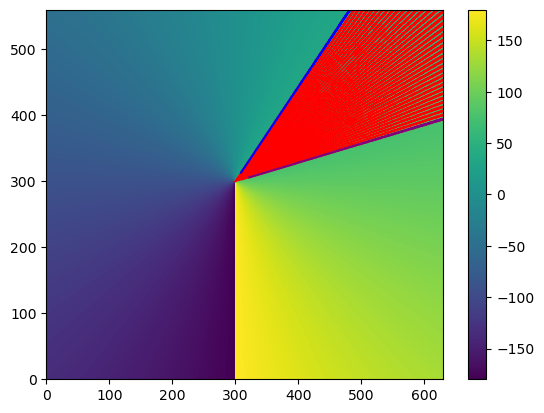

In [17]:
plt.pcolormesh(lon_rho)
plt.colorbar()

# what if we get a series of indices where lon_rho is close to a value
lon_desired = np.arange(35,75,1)
lon_indices = np.full((40,2,800),np.nan)
for lon in range(len(lon_desired)):
    indices = np.where((lon_rho > lon_desired[lon] - 0.15) & (lon_rho < lon_desired[lon] + 0.15))
    
    # we can trim these so they're all the same shape
    #print(indices[0].shape)
    lon_indices[lon,0,:len(indices[0])] = np.array(indices[0])
    lon_indices[lon,1,:len(indices[0])] = np.array(indices[1])

    #plt.plot(indices[1],indices[0],color="red")
    
for i in range(40):
    #print(len(lon_indices[i,1,:]))#
    plt.plot(lon_indices[i,1,:],lon_indices[i,0,:],color="red")
    
plt.plot(lon_indices[0,1,:],lon_indices[0,0,:],color="blue")
plt.plot(lon_indices[-1,1,:],lon_indices[-1,0,:],color="purple")

endpoints1 = np.array([[lon_indices[0,1,0],lon_indices[0,0,0]],[lon_indices[0,1,-1],lon_indices[0,0,-1]]])
endpoints2 = np.array([[lon_indices[-1,1,0],lon_indices[-1,0,0]],[lon_indices[-1,1,-1],lon_indices[-1,0,-1]]])

In [18]:
# plt.pcolormesh(lat_rho)
# plt.colorbar()
    
# # at each value latitude, go along and find the delta long
# lat_desired = np.arange(-55,-75,-1)
# lat_indices = np.full((20,2,5000),np.nan)
# for lat in range(len(lat_desired)):
#     indices = np.where((lat_rho > lat_desired[lat] - 0.1) & (lat_rho < lat_desired[lat] + 0.1))
    
#     # we can trim these so they're all the same shape
#     #print(indices[0].shape)
#     lat_indices[lat,0,:len(indices[0])] = np.array(indices[0])
#     lat_indices[lat,1,:len(indices[0])] = np.array(indices[1])#
    
# for i in range(20):
#     #print(len(lon_indices[i,1,:]))#
#     plt.plot(lat_indices[i,1,:],lat_indices[i,0,:],color="red")
    
# plt.plot(lon_indices[0,1,:],lon_indices[0,0,:],color="blue")
# plt.plot(lon_indices[-1,1,:],lon_indices[-1,0,:],color="purple")

In [19]:
# dlon
dlon = np.full((lon_rho.shape),np.nan)

# for each two lines in longitude:
for i in range(40-1):
    x1 = lon_indices[i,1,:][~np.isnan(lon_indices[i,1,:])]
    y1 = lon_indices[i,0,:][~np.isnan(lon_indices[i,0,:])]
    x2 = lon_indices[i+1,1,:][~np.isnan(lon_indices[i+1,1,:])]
    y2 = lon_indices[i+1,0,:][~np.isnan(lon_indices[i+1,0,:])]
    
    # get the array of lat_rho values at each point for the two arrays
    lat1 = np.array([lat_rho[int(i), int(j)] for i, j in zip(y1, x1)])
    lat2 = np.array([lat_rho[int(i), int(j)] for i, j in zip(y2, x2)])
    
    min_length = min(len(lat1), len(lat2))
    
    x1,x2,y1,y2,lat1,lat2 = x1[:min_length],x2[:min_length],y1[:min_length],y2[:min_length],lat1[:min_length],lat2[:min_length]
    
    # for each point in the first line
    for xi, yi,lati in zip(x1,y1,lat1):
        # get the closest value in the next array in latitude
        i = np.abs(lat2 - lati).argmin()
        
        # get the x y indices
        p1 = np.array([xi, yi])
        p2 = np.array([x2[i], y2[i]])

        # Calculate the Euclidean distance
        dist = np.linalg.norm(p1 - p2)
        
        # add distance to the mask
        dlon[yi.astype(int),xi.astype(int)] = dist

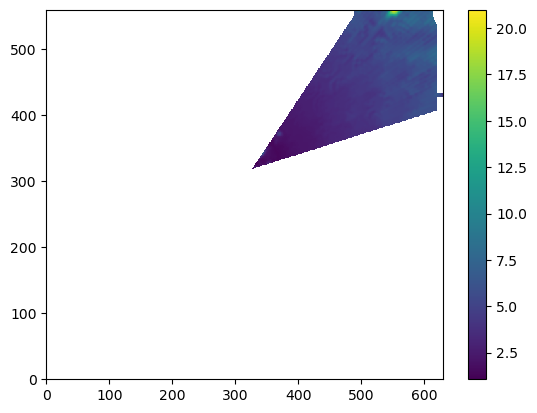

In [20]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter


# Assuming dlon is your sparse matrix

# Generate grid coordinates
x = np.arange(dlon.shape[1])
y = np.arange(dlon.shape[0])
X, Y = np.meshgrid(x, y)

# Mask invalid values
mask = ~np.isnan(dlon)

# Interpolate using griddata
dlon_interp = griddata((X[mask], Y[mask]), dlon[mask], (X, Y), method='cubic')
smoothed_dlon = gaussian_filter(dlon_interp, sigma=2)

# Plot interpolated data
plt.figure()
plt.pcolormesh(smoothed_dlon)
plt.colorbar()

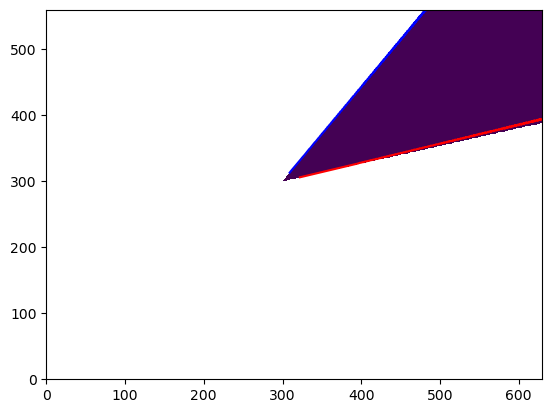

In [21]:
msk = np.full((lon_rho.shape),np.nan)
plt.plot(lon_indices[0,1,:],lon_indices[0,0,:],color="blue")
plt.plot(lon_indices[-1,1,:],lon_indices[-1,0,:],color="red")

indices = np.logical_and(lon_rho > 35, lon_rho < 75)

# Set mask values to 1 where the condition is satisfied
msk[indices] = 1
            
plt.pcolormesh(msk)

In [22]:
dens1 = dens[1][:,:-1,:-1]
dens1.shape
np.nanmax(dens1)

NameError: name 'dens' is not defined

In [23]:
def calculate_streamfunction(mer_speed, dlon, rho, dz, rhobins):
    """
    Calculate stream function Ψ(z) from ROMS velocity components
        
    Returns:
        stream_function (numpy.ndarray): Stream function values at each density.
    """
    stream_function = np.zeros(rhobins.shape)
    
    # element-wise and summation
    volume = mer_speed * dlon * dz
    bin_i = np.digitize(rho,rhobins) - 1
    masked_volume = np.ma.masked_invalid(volume)
    masked_bin_i = np.ma.masked_where(masked_volume.mask, bin_i)
    stream_function += np.bincount(masked_bin_i.compressed(), weights=masked_volume.compressed() / 1e6, minlength=len(rhobins))
    
    #stream_function += np.bincount(bin_i.ravel(), weights=volume.ravel() / 1e6, minlength=len(rhobins))
    
    return volume,masked_bin_i,stream_function


dens1 = dens[0][:,:-1,:-1]
dlon = smoothed_dlon * 10000 # m instead of 10s of km
dlon = np.tile(smoothed_dlon[np.newaxis,:-1,:-1],(30,1,1))

dz = np.diff(ds1.z_rho[0],axis=0)[:,:-1,:-1]
dz = dz * np.tile(msk[np.newaxis,:-1,:-1],(30,1,1))
mer_speed1 = (mer_speed[0][1:,:,:] + mer_speed[0][:-1,:,:])/2      # average so we can multiply by dz
dens1 = (dens1[1:,:,:] + dens1[:-1,:,:])/2      # average so we can multiply by dz
dens1 = dens1 * np.tile(msk[np.newaxis,:-1,:-1],(30,1,1))

print(mer_speed1.shape,dlon.shape,dens1.shape,dz.shape)

rhobins = np.linspace(np.nanmin(dens1), np.nanmax(dens1)+0.1, 30)

mer_speed1a, dlona, dens1a, dza = mer_speed1, dlon, dens1, dz

# Calculate the stream function
volume,bin_i,stream_function = calculate_streamfunction(mer_speed1, dlon, dens1, dz, rhobins)

NameError: name 'dens' is not defined

In [24]:
plt.plot(stream_function,rhobins)

NameError: name 'stream_function' is not defined

### Let's try to do this with all the datasets

In [25]:
dz = ds1.z_rho[:,:,:,0]
print(dz.shape)
dz = np.diff(dz,axis=0)[:,:-1,:-1]
dz = dz * np.tile(msk[np.newaxis,:-1,:-1],(30,1,1))

AttributeError: 'Dataset' object has no attribute 'z_rho'

In [32]:
# this is here based on the definition that sigma > 27.82 is DSW/mSW/AABW
### dlon will be the same every time
dlon = smoothed_dlon * 10000 # m instead of 10s of km
dlon = np.tile(smoothed_dlon[np.newaxis,:-1,:-1],(30,1,1)) 

### dz will be the same every time
dz = np.diff(ds1.z_rho[0],axis=0)[:,:-1,:-1]
dz = dz * np.tile(msk[np.newaxis,:-1,:-1],(30,1,1))

print(dlon.shape,dz.shape)

(30, 559, 629) (30, 559, 629)


(4, 31, 559, 629)
(4, 30, 559, 629)


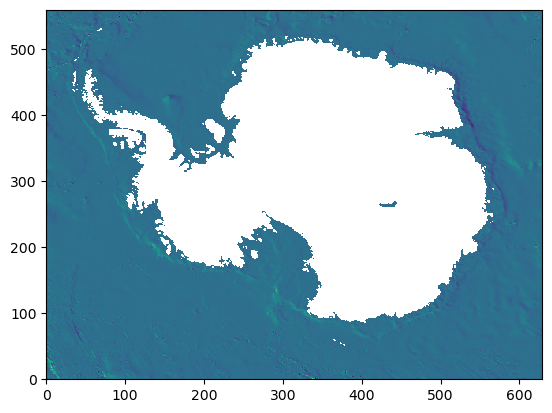

In [33]:
u = ds4.u[:,:,:-1,:]
v = ds4.v[:,:,:,:-1]
mer_speed = calculate_along_latitude_velocity(u,v,lat_rho[:-1,:-1])
print(mer_speed.shape)
mer_speed1 = (mer_speed[:,1:,:,:] + mer_speed[:,:-1,:,:])/2
print(mer_speed1.shape)
plt.pcolormesh(mer_speed1[0,0])

In [34]:
rhobins = np.linspace(23.9, 28+0.1, 30)
# rhobins = np.arange(24,28.6,0.2)

In [42]:
dz.shape

(30, 559, 629)

In [44]:
idx = 0
streams = np.zeros((48,rhobins.shape[0]))
#for ds in ,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
for ds in ds1,ds2,ds3,ds4,ds5,ds6,ds7,ds8,ds9,ds10,ds11,ds12:
    print("set",idx)
    dens1 = np.zeros((4,31,560,630))
    
    #### create the density matrix
    temp = ds.variables["temp"]
    salt = ds.variables["salt"]
    
    dens1 = dens1 + gsw.rho(salt,temp,0)-1000
    dens1 = (dens1[:,1:,:,:] + dens1[:,:-1,:,:])/2      # average so we can multiply by dz
    if not dens1.shape == np.tile(msk[np.newaxis,np.newaxis,:-1,:-1],(4,30,1,1)).shape:
        dens1 = dens1[:,:,:-1,:-1]
    dens1 = dens1 * np.tile(msk[np.newaxis,np.newaxis,:-1,:-1],(4,30,1,1))
    
    ### get the meridional speed
    u = ds.u[:,:,:-1,:]
    v = ds.v[:,:,:,:-1]
    mer_speed = calculate_along_latitude_velocity(u,v,lat_rho[:-1,:-1])
    mer_speed1 = np.abs((mer_speed[:,1:,:,:] + mer_speed[:,:-1,:,:])/2)     # average so we can multiply by dz
    
    # not sure if we should do np. abs here!!
    
    ### get the rhobins
    #rhobins = np.linspace(np.nanmin(dens1), np.nanmax(dens1)+0.1, 30)
    
    ### now we can do the streamfunction!
    for i in range(mer_speed1.shape[0]):
        
        ### dz will be the same every time
        dz = np.diff(ds.z_rho[i],axis=0)[:,:-1,:-1]
        dz = dz * np.tile(msk[np.newaxis,:-1,:-1],(30,1,1))
    
        volume,bin_i,stream_function = calculate_streamfunction(mer_speed1[i], dlon, dens1[i], dz, rhobins)
        streams[idx] = stream_function
        idx += 1

set 0
set 4
set 8
set 12
set 16
set 20
set 24
set 28
set 32
set 36
set 40
set 44


Text(0, 0.5, 'Density (kg/m^3) - 1000')

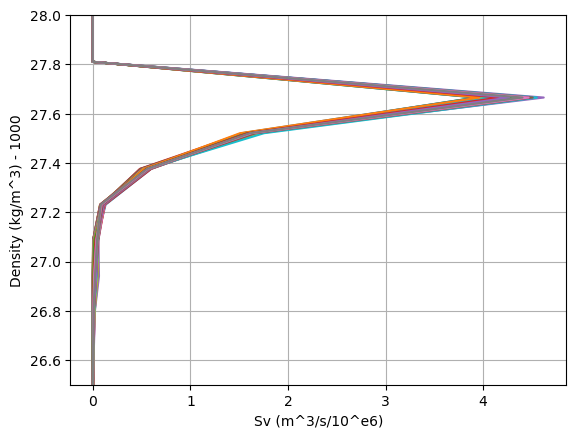

In [56]:
##### fig = plt.figure()
for i in range(48):
    plt.plot(streams[i],rhobins,label=i)
plt.ylim([26.5,28])
plt.grid()
plt.xlabel("Sv (m^3/s/10^e6)")
plt.ylabel("Density (kg/m^3) - 1000")

### Now can we loop through the time steps to create averages or sums?

Text(0, 0.5, 'Density (kg/m^3) - 1000')

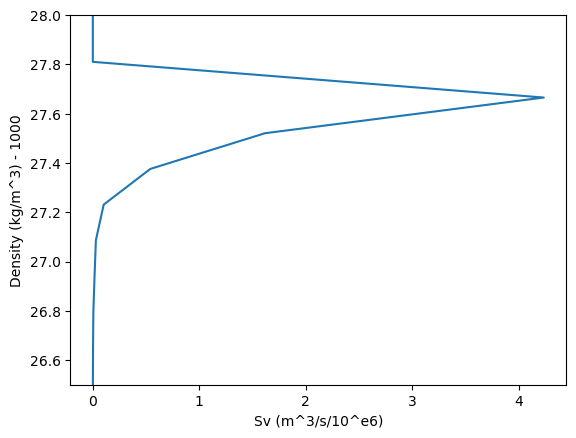

In [54]:
stream_mean = np.mean(streams,axis=0)
fig = plt.figure()
plt.plot(stream_mean,rhobins)
plt.ylim([26.5,28])
plt.xlabel("Sv (m^3/s/10^e6)")
plt.ylabel("Density (kg/m^3) - 1000")

In [67]:
print(rhobins[-3:])
print(stream_mean[-3])

[27.81034483 27.95517241 28.1       ]
4.311115779123114e-05
